In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns

from scipy import stats
from matplotlib import pyplot as plt

In [2]:
# Make a color palette for the swarmplot that colors replicates differently.
greys = sns.color_palette('Greys', n_colors=8)
greens = sns.color_palette('Greens', n_colors=8)
purples = sns.color_palette('Purples', n_colors=8)
reddish_purple = sns.set_hls_values(sns.xkcd_rgb['reddish purple'], 0.9, 0.3, 1)

In [3]:
# Load bioreactor data 

# Culture density data from bioreactor pumping ambient air from 08/31/19.
# Note: first 19 rows are metadata for the experiment.
bioreactor_continuous_df = pd.read_csv('data/fig3/083119_CCMB1_bioreactor_continuous.csv', skiprows=19)
# Column names have whitespace off the machine - fix manually.
bioreactor_continuous_df.columns = [x.strip() for x in bioreactor_continuous_df.columns]

In [4]:
# Mapping of names to specific bioreactor tube labels.
bioreactor_mapping = {'recon.1': 'od-sensors-1.od-680 ',
                      'recon.2': 'od-sensors-2.od-680 ',
                      'recon.4': 'od-sensors-3.od-680 ',
                      'K194M.3': 'od-sensors-4.od-680 ',
                      'K194M.4': 'od-sensors-5.od-680 ',
                      'lsPrk.3': 'od-sensors-6.od-680 ',
                      'lsPrk.4': 'od-sensors-7.od-680 ',
                      'pos': 'od-sensors-8.od-680 ',
                     }

# Which ones to plot and colors for them.
bioreactor_names2plot = {'recon.4': purples[-2],
                         'lsPrk.3': greens[-2]}

In [5]:
# Load endpoint growth data of mutants

# Endpoint data (4 days) from matched 3mL cultures in 10% CO2 and ambient. 
matched_od_df = pd.read_csv('data/fig3/090619_CCMB1_mutants_endpointODs_tubes.csv')
amb_df = matched_od_df[matched_od_df.condition == 'amb']
highCO2_df = matched_od_df[matched_od_df.condition == '10% CO2']

# Calculate mean values for the 3mL scale experiment. 
mean_10pct = highCO2_df.groupby('strain_name').mean()
mean_amb = amb_df.groupby('strain_name').mean()

std_10pct = highCO2_df.groupby('strain_name').std()
std_amb = amb_df.groupby('strain_name').std()

In [6]:
# Load amino acid LCMS data
float_types = ['ser', 'his', 'val', 'thr', 'pro', 'arg', 'glu']
short_names = float_types
long_names = ['Serine', 'Histidine', 'Valine', 'Threonine', 'Proline', 'Arginine', 'Glutamate']
dtypes = dict((aa, pd.np.float64) for aa in float_types)
fname = 'data/fig4/022720_repeat_f13c_extracted_transpose.csv'

# Data is the fraction of C atoms that are 13C
frac13c_df = pd.read_csv(fname, index_col=0, na_values='NAN', dtype=dtypes)

# Convert data to fraction 12C from fraction 13C
frac12c_df = frac13c_df.copy()
frac12c_df[float_types] = 1.0 - frac13c_df[float_types]

In [7]:
# LCMS calculations 

# Calculate the intracellular 13C and 12C fractions by comparing arginine with glutamate and proline.
# Calculation following Gleizer et al. Cell 2019 - averaging inference from glu and pro inference.
f13c_cyto_glu = 6 * frac13c_df.arg - 5 * frac13c_df.glu
f13c_cyto_pro = 6 * frac13c_df.arg - 5 * frac13c_df.pro

# negative values are non-sensical
epsilon = 1e-3
f13c_cyto_glu[f13c_cyto_glu < 0] = epsilon
f13c_cyto_pro[f13c_cyto_pro < 0] = epsilon

# handy summary dataframe for checking the calculation
df_data = {'sample_name': frac13c_df.sample_name, 'f13c_cyto_glu': f13c_cyto_glu, 'f13c_cyto_pro': f13c_cyto_pro}
cyto_ci_isotopes_df = pd.DataFrame(df_data)
cyto_ci_isotopes_df['mean_f13c_cyto'] = cyto_ci_isotopes_df[['f13c_cyto_glu', 'f13c_cyto_pro']].mean(axis=1)
cyto_ci_isotopes_df['f12c_cyto_inferred'] = 1.0 - cyto_ci_isotopes_df.mean_f13c_cyto

# Calculate the mean f12c for the controls - need this below
mean_isotope_df = cyto_ci_isotopes_df.groupby('sample_name').mean()
mean_control_f12c_cyto = mean_isotope_df.loc['CAfree_bioreactor'].f12c_cyto_inferred
print('Average control has %.1f%% 12C in the cytosol' % (100*mean_control_f12c_cyto))

# Now we ask: what fraction of that 12C makes it onto serine in the control. 
mean_AA_labeling_df = frac12c_df.groupby('sample_name').mean()
mean_control_f12c_ser = mean_AA_labeling_df.loc['CAfree_bioreactor'].ser
baseline_12c_cycling_ser = mean_control_f12c_cyto / mean_control_f12c_ser
print('Control has an average of %.1f%% 12C on serine' % (100*mean_control_f12c_ser))
print('This is 1/%.1f of the cytosolic 12C pool' % (baseline_12c_cycling_ser))

# Consider: if this is the baseline for the control, but the experiment has a
# different amount of cytosolic 12C, what should we expect from the experiment? 
expected_baseline_ser = cyto_ci_isotopes_df.f12c_cyto_inferred / baseline_12c_cycling_ser

# We predict a 2.1% increase in serine labeling from FBA, but not all the CO2 fixes will be 12c.
# So the prediction is the baseline above + 2.1% rescaled (downward) by the cytosolic 12C fraction
predicted_serine_f12C = expected_baseline_ser + (0.021)*cyto_ci_isotopes_df.f12c_cyto_inferred

# Make a data frame of predictions and measurements for plotting
df_data = {'f12c_ser_measured': frac12c_df.ser, 'f12c_ser_predicted': predicted_serine_f12C,
           'sample_name': frac12c_df.sample_name}
predict_and_measure_df = pd.DataFrame(df_data)

names = ['control']*4 + ['prediction']*4 + ['experiment']*4
values = predict_and_measure_df[
    predict_and_measure_df.sample_name == 'CAfree_bioreactor'].f12c_ser_measured.to_list()
values += predict_and_measure_df[
    predict_and_measure_df.sample_name == 'CCMB1_bioreactor'].f12c_ser_predicted.to_list()
values += predict_and_measure_df[
    predict_and_measure_df.sample_name == 'CCMB1_bioreactor'].f12c_ser_measured.to_list()

# Convert to percent for plotting
lcms_plotting_df = pd.DataFrame({'sample_name': names, 'f12c_ser': 100*np.array(values)})
lcms_plotting_df

Average control has 30.2% 12C in the cytosol
Control has an average of 0.6% 12C on serine
This is 1/48.7 of the cytosolic 12C pool


,sample_name,f12c_ser
0,control,0.452685
1,control,0.899821
2,control,0.349472
3,control,0.783520
4,prediction,1.902075
5,prediction,3.944377
6,prediction,3.961080
7,prediction,2.010362
8,experiment,2.476675
9,experiment,2.863817


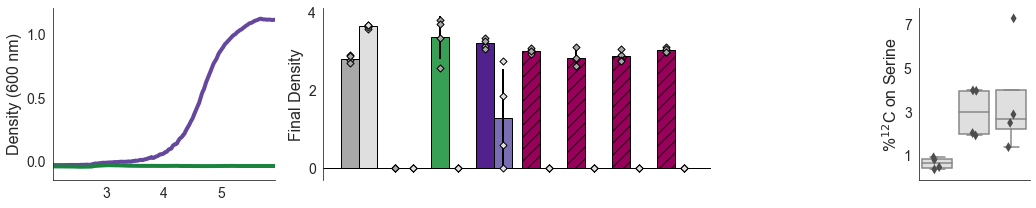

In [11]:
fig = plt.figure(figsize=(14.5, 3))
#sns.set_style('white')
gs = fig.add_gridspec(nrows=1, ncols=4, width_ratios=[4, 7, 2, 2])

# bioreactor growth curves
ax0 = fig.add_subplot(gs[0, 0])

for name, color in bioreactor_names2plot.items():
    # 'key' is the name of the measurement/well we are looking at. 
    key = bioreactor_mapping[name]
    my_tube = bioreactor_continuous_df[bioreactor_continuous_df['key'] == key]
    
    times = my_tube.time.values
    ods = pd.Series(my_tube.value.values)
    median_filtered_ods = ods.rolling(5).median()
    smoothed_ods = median_filtered_ods.rolling(10).mean()
    plt.plot(times, smoothed_ods, lw=4, color=color)

plt.xticks(np.arange(0, 144, 24), np.arange(0, 144, 24)//24, fontsize=14)
plt.yticks(np.arange(0.0, 1.01, 0.5), fontsize=14)

plt.xlim(50, 142)
plt.ylim(-0.15, 1.21)

# hide xlabel for illustrator
#plt.xlabel('Time (Days)', fontsize=16)
plt.ylabel('Density (600 nm)', fontsize=16)
sns.despine(ax=ax0)



# matched cultures in 10% CO2 and ambient
ax1 = fig.add_subplot(gs[0, 1])

custom_pal = {'10% CO2': greys[3], 'amb': greys[1]}

order = ['CAfree+EGFP/HCAII', 'lsK194M/AGFP', 'ls/AGFP', '13.6 recons',
 '13.6 C173s/Ccm11', '13.6 dS2/Ccm11', '13.6 d4AB/Ccm11', '13.6 Cb11/ dDab1', ]
ticknames = ['Pos.', "Neg.", 'p1A/vec', "pCB'/pCCM'",
 "pCB' csosCA$^-$/pCCM'", "pCB' csos2-$\Delta$NTD/pCCM'", "pCB' $\Delta$csos4AB/pCCM'",
 "pCB'/pCCM' DabA1$^-$", ]

bars_10pct = [
    greys[3], greys[3], # controls - grey
    # Rubisco alone/no carboxysome - green
    greens[-3],
    # Full CCM gene set
    purples[-1],
    # Mutants with most of the CCM are red/purple
    reddish_purple, reddish_purple, reddish_purple, reddish_purple]

bars_amb = [
    greys[1], greys[1],
    greens[-5],
    purples[-3],
    reddish_purple, reddish_purple, reddish_purple, reddish_purple]

xs = np.arange(len(order))

width = 0.4
offset = width/2
bars_10pct = plt.bar(xs-offset, mean_10pct.loc[order].OD.values, color=bars_10pct, width=width, edgecolor='k')
plt.bar(xs+offset, mean_amb.loc[order].OD.values, color=bars_amb, width=width, edgecolor='k')

for bar in bars_10pct[-4:]:
    bar.set_hatch('//')

for i, name in enumerate(order):
    my_xs = np.ones(4)*i
    plt.scatter(my_xs-offset, highCO2_df[highCO2_df.strain_name == name].OD.values,
                marker='D', s=25, color=greys[3], edgecolors='k', zorder=10)
    plt.scatter(my_xs+offset, amb_df[amb_df.strain_name == name].OD.values,
                marker='D', s=25, color=greys[1], edgecolors='k', zorder=10)

# TODO: prefer 95% CI to std deviation
plt.errorbar(xs-0.2, mean_10pct.loc[order].OD.values, yerr=std_10pct.loc[order].OD.values, color='k', ls='', elinewidth=2)
plt.errorbar(xs+0.2, mean_amb.loc[order].OD.values, yerr=std_amb.loc[order].OD.values, color='k', ls='', elinewidth=2)
plt.axhline(0, lw=1, c='k')

# hiding xticks for illustrator
#plt.xticks(np.arange(len(ticknames)), ticknames, rotation=45, fontsize=14, ha='right')
plt.xticks([])
plt.yticks(np.arange(0, 4.1, 2.0), fontsize=14)
plt.xlabel('')
plt.ylabel('Final Density', fontsize=16)
sns.despine(bottom=True, ax=ax1)



# matched cultures in 10% CO2 and ambient
ax3 = fig.add_subplot(gs[0, 3])

lr_order = ['control', 'prediction', 'experiment']
sns.boxplot(data=lcms_plotting_df, x='sample_name', y='f12c_ser',
            order=lr_order, color=greys[1], showfliers=False)
sns.stripplot(data=lcms_plotting_df, x='sample_name', y='f12c_ser', order=lr_order, 
              color='0.3', marker='d', size=7)


yl = '%$^{12}$C on Serine'
plt.ylabel(yl, fontsize=16)
plt.yticks([1, 3, 5, 7], fontsize=14)

# hide xticks for illustrator
#plt.xticks(fontsize=14, rotation=45, ha='right')
plt.xticks([])
plt.xlabel('')

sns.despine(ax=ax3)


plt.tight_layout()
plt.savefig('fig3/fig3bcde.png', dpi=600)
plt.show()

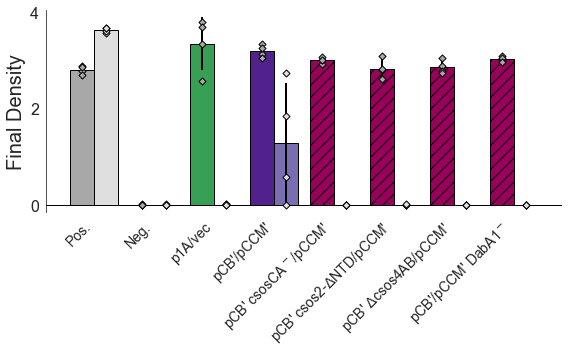

In [9]:
# Presentation version of the genetic tests of the CCM.
# Skipping a few of the controls that are not needed. 
plt.figure(figsize=(8,5))
sns.set_style('white')

custom_pal = {'10% CO2': greys[3], 'amb': greys[1]}

order = ['CAfree+EGFP/HCAII', 'lsK194M/AGFP', 'ls/AGFP', '13.6 recons',
 '13.6 C173s/Ccm11', '13.6 dS2/Ccm11', '13.6 d4AB/Ccm11', '13.6 Cb11/ dDab1', ]
ticknames = ['Pos.', "Neg.", 'p1A/vec', "pCB'/pCCM'",
 "pCB' csosCA$^-$/pCCM'", "pCB' csos2-$\Delta$NTD/pCCM'", "pCB' $\Delta$csos4AB/pCCM'",
 "pCB'/pCCM' DabA1$^-$", ]

bars_10pct = [
    greys[3], greys[3], # controls - grey
    # Rubisco alone/no carboxysome - green
    greens[-3],
    # Full CCM gene set
    purples[-1],
    # Mutants with most of the CCM are red/purple
    reddish_purple, reddish_purple, reddish_purple, reddish_purple]

bars_amb = [
    greys[1], greys[1],
    greens[-5],
    purples[-3],
    reddish_purple, reddish_purple, reddish_purple, reddish_purple]

xs = np.arange(len(order))

width = 0.4
offset = width/2
bars_10pct = plt.bar(xs-offset, mean_10pct.loc[order].OD.values, color=bars_10pct, width=width, edgecolor='k')
plt.bar(xs+offset, mean_amb.loc[order].OD.values, color=bars_amb, width=width, edgecolor='k')

for bar in bars_10pct[-4:]:
    bar.set_hatch('//')

for i, name in enumerate(order):
    my_xs = np.ones(4)*i
    plt.scatter(my_xs-offset, highCO2_df[highCO2_df.strain_name == name].OD.values,
                marker='D', s=25, color=greys[3], edgecolors='k', zorder=10)
    plt.scatter(my_xs+offset, amb_df[amb_df.strain_name == name].OD.values,
                marker='D', s=25, color=greys[1], edgecolors='k', zorder=10)

# TODO: prefer 95% CI to std deviation
plt.errorbar(xs-0.2, mean_10pct.loc[order].OD.values, yerr=std_10pct.loc[order].OD.values, color='k', ls='', elinewidth=2)
plt.errorbar(xs+0.2, mean_amb.loc[order].OD.values, yerr=std_amb.loc[order].OD.values, color='k', ls='', elinewidth=2)
plt.axhline(0, lw=1, c='k')

plt.xticks(np.arange(len(ticknames)), ticknames, rotation=45, fontsize=14, ha='right')
plt.yticks(np.arange(0, 4.1, 2.0), fontsize=16)
plt.xlabel('')
plt.ylabel('Final Density', fontsize=20)
plt.ylim(-0.15, 4.05)
sns.despine(bottom=True)
plt.tight_layout()

plt.savefig('fig3/fig3c.png', dpi=300)
plt.show()